In [1]:
from typing import List, Optional
from autograd import grad, jacobian, elementwise_grad
import numpy as np
import matplotlib.pyplot as plt
import sys, os
from tqdm import tqdm
import math
import scipy 
from scipy import linalg
from numpy import linalg as LA
from pyblas.level1 import dnrm2

sys.path.insert(0, os.path.join(".."))
%load_ext autoreload
%autoreload 2

In [2]:
from lib import problems as pr
from lib import optimisers as opt
from lib import utils as ut

In [2]:
L_x, L_y, mu_x, mu_y = 1, 1, 0.5, 0.2
L_xy, mu_xy, mu_yx = 3, 2, 1

rho_a, rho_b, rho_c, rho_d = -np.inf, -np.inf, -np.inf, -np.inf

if (mu_x > 0) and (mu_y > 0):
    delta = (mu_y / mu_x)**.5
    sigma_x = (mu_x / (2 * L_x))**.5
    sigma_y = (mu_y / (2 * L_y))**.5
    rho_a = 4 + 4 * max((L_x / mu_x)**.5,
                    (L_y / mu_y)**.5,
                    L_xy / (mu_x * mu_y)**.5)
elif (mu_x > 0) and (mu_y == 0):
    delta = (mu_xy**2 / (2*mu_x*L_x))**.5
    sigma_x = (mu_x / (2 * L_x))**.5
    sigma_y = min(1, (mu_xy**2 / (4*L_x*L_y))**.5)
    rho_b = 4 + 8 * max((L_x * L_y)**.5 / mu_xy,
                    L_xy / mu_xy * (L_x / mu_x)**.5,
                    L_xy**2 / mu_xy**2)
elif (mu_x == 0) and (mu_y > 0):
    delta = (2*mu_y**2 * L_y / mu_yx**2)**.5
    sigma_x = min(1, (mu_yx**2 / (4*L_x*L_y))**.5)
    sigma_y = (mu_y / (2 * L_y))**.5
    rho_c = 4 + 8 * max((L_x * L_y)**.5 / mu_yx,
                        L_xy / mu_yx *(L_y / mu_y)**.5,
                        L_xy**2 / mu_xy**2)
elif (mu_x == 0) and (mu_y == 0):
    delta = (mu_xy / mu_yx)*(L_y / L_x)**.5
    sigma_x = min(1, (mu_yx**2 / (4*L_x*L_y))**.5)
    sigma_y = min(1, (mu_yx**2 / (4*L_x*L_y))**.5)
    rho_d = 2 + 8 * max((L_x * L_y)**.5 * L_xy / (mu_xy * mu_yx),
                    L_xy**2 / mu_yx**2,
                    L_xy**2 / mu_xy**2)

theta = 1 - max(rho_a, rho_b, rho_c, rho_d)
eta_x = min(1 / (4 * (mu_x + L_x * sigma_x)), delta/(4*L_xy))
eta_y = min(1 / (4 * (mu_y + L_y * sigma_y)), 1/(4*L_xy * delta))
tau_x = (sigma_x**(-1) + 0.5)**(-1)
tau_y = (sigma_y**(-1) + 0.5)**(-1)
alpha_x = mu_x
alpha_y = mu_y
beta_x = min(1/(2*L_y), 1/(1*eta_x*L_xy**2))
beta_y = min(1/(2*L_x), 1/(1*eta_y*L_xy**2))

In [3]:
A = 0.5 + 0.1 * np.random.randn(5, 6)

In [4]:
import scipy.linalg as sla

# TODO: We need only lam_max, lam+_min and lam_min/ Faster way?
spectrum = sla.svd(A.T.dot(A))[1]
L_xy = spectrum.max()**.5
mu_yx = spectrum.min() 
mu_xy = sla.svd(A.dot(A.T))[1].min()

**Evaluation**

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1272.12it/s]


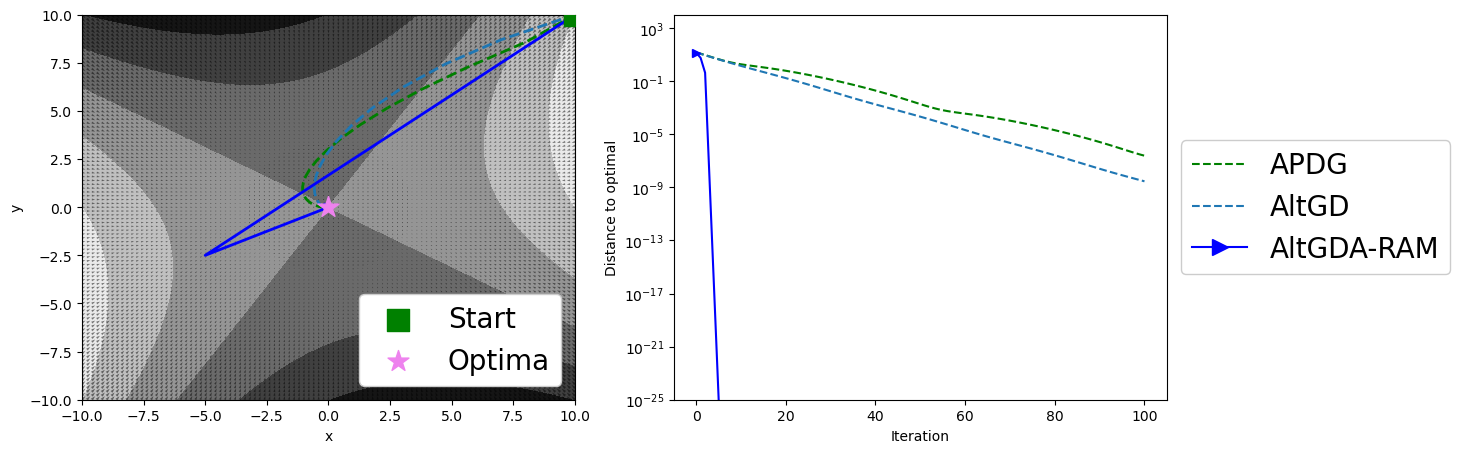

In [25]:


figname = 'APDG__opt.png'
FIG_DIR = os.path.join("..", "figures")
if not os.path.exists(FIG_DIR):
    os.mkdir(FIG_DIR)
    
k = 5
markevery= 10
x0, y0 = np.array([10.]),np.array([10.])
A = np.eye(1, 1)

problem = pr.func2(A=A)
xopt, yopt = problem.xopt, problem.yopt
params = {"apdg": None,
          'altgd': 0.1,
          'AA': 0.5
         }
xmin, xmax, xstep = (-10, 10, .2)
ymin, ymax, ystep = (-10, 10, .2)
 # {'simgd':0.05, 'altgd':0.1, 'avg':1, 'adam':0.01, 'eg':0.6,'omd':0.3, 'fr':0.05,'AA':0.5}
f = problem.f
g = problem.g

type2=True
iteration = 100
loss_f3, xpath_f3, ypath_f3 = ut.main(problem, iteration, x0.copy(), y0.copy(), params, k=k)

x, y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))
z = lambda x, y: f(x, y) - g(x, y) + x * A * y
z = z(x, y)
dz_dx = elementwise_grad(f, argnum=0)(x, y)
dz_dy = elementwise_grad(g, argnum=1)(x, y)
ut.plot(x, y, z, dz_dx, dz_dy, 
        loss_f3, xpath_f3, ypath_f3, iteration, k, 
        start=(x0, y0), solution=(xopt, yopt), 
        ranges={"x": (-10, 10, .2),
                "y": (-10, 10, .2)
               }, figname=figname,
        fig_dir=FIG_DIR, markevery=10)

## Ndim

In [20]:
problem_n = pr.GeneralSaddle(n=3, spd=True)
params = {'apdg': None,
          'altgd': 0.1,
          'AA': 0.5
         }
 # {'simgd':0.05, 'altgd':0.1, 'avg':1, 'adam':0.01, 'eg':0.6,'omd':0.3, 'fr':0.05,'AA':0.5}

x0 = np.random.randn(3, )
y0 = np.random.randn(3, )
type2=True
iteration = 100
k =  10
loss_f3, xpath_f3, ypath_f3 = ut.main(problem_n, iteration, x0.copy(), y0.copy(), params, k=k)

spd
bc zeros


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2220.14it/s]


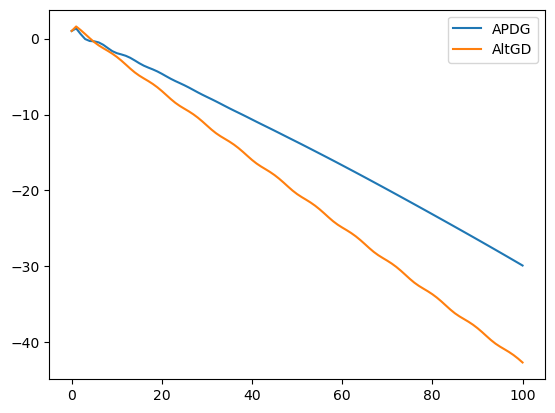

In [26]:
%matplotlib inline
import numpy as np
plt.plot(np.log(loss_f3[0]), label="APDG")
plt.plot(np.log(loss_f3[1]), label="AltGD")
plt.legend()

**Making matrix with predefined $L_{xy}, \mu_{xy}, \mu_{yx}$**

In [98]:
import scipy.linalg as sla
from scipy.stats import ortho_group 

lambda_min, lambda_max = 1, 10
n = 10

def get_A_fixed(lambda_min, lambda_max, n):
    eigenvals = np.zeros(n)
    eigenvals[1:-1] = np.random.randint(low=lambda_min**2, 
                                        high=lambda_max**2,
                                        size=n - 2)
    eigenvals[0] = lambda_min**2
    eigenvals[-1] = lambda_max**2
    S = np.diag(eigenvals)

    Q = ortho_group.rvs(dim=n)
    return sla.sqrtm(Q.T @ S @ Q)

In [99]:
_A = get_A_fixed(lambda_min, lambda_max, n)

In [100]:
sla.svd(_A)[1]

array([10.        ,  9.79795897,  9.59166305,  9.32737905,  8.83176087,
        8.77496439,  6.70820393,  3.60555128,  1.41421356,  1.        ])

In [102]:
sla.svd(_A.T.dot(_A))[1]

array([100.,  96.,  92.,  87.,  78.,  77.,  45.,  13.,   2.,   1.])

In [104]:
sla.svd(_A.dot(_A.T))[1]

array([100.,  96.,  92.,  87.,  78.,  77.,  45.,  13.,   2.,   1.])

**Nontrivial example**

In [21]:
import autograd.numpy as np
import lib.utils as ut


class func3(pr.BaseSaddle):
    def __init__(self, n):
        L_xy = 1
        mu_xy = 0.25
        mu_yx = 0.25
        A = ut.get_A_fixed(mu_xy, L_xy, n=n)
        super().__init__(A=A)
        self.L_xy = L_xy
        self.mu_xy = mu_xy
        self.mu_yx = mu_yx
        self.A = A
        
        
        self.f = lambda x, y: x.transpose() @ x
        self.g = lambda x, y:  y.transpose() @ y
        self.L_x = 2
        self.mu_x = 2
        
        self.L_y = 2
        self.mu_y = 2
        
        self.xopt = LA.solve(self.A.transpose(), np.zeros((n, 1)))
        self.yopt = LA.solve(self.A, np.zeros((n, 1))) 
        self.constraint=False   
        self.dfdx = grad(self.f)
        self.dfdy = 0  
        self.dgdx = 0
        self.dgdy = grad(self.g, 1)  
        self.d2fdxdx = grad(self.dfdx)
        self.d2fdydy = grad(self.dfdy, 1)
        self.d2fdxdy = grad(self.dfdx, 1)
        self.d2fdydx = grad(self.dfdy)

In [22]:
n = 3
problem_ndim = func3(n=n)
params = {'apdg': None,
          'altgd': 0.1,
          'AA': 0.5
         }
 # {'simgd':0.05, 'altgd':0.1, 'avg':1, 'adam':0.01, 'eg':0.6,'omd':0.3, 'fr':0.05,'AA':0.5}

x0 = np.ones(n, )
y0 = np.ones(n, )
type2=True
iteration = 100
k =  10
loss_f3, xpath_f3, ypath_f3 = ut.main(problem_ndim, iteration, x0.copy(), y0.copy(), params, k=k)

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1338.51it/s]


In [23]:
import scipy.linalg as sla
sla.svd(problem_ndim.A)[1]

array([1.00000000e+00, 2.50000000e-01, 6.68186383e-09])

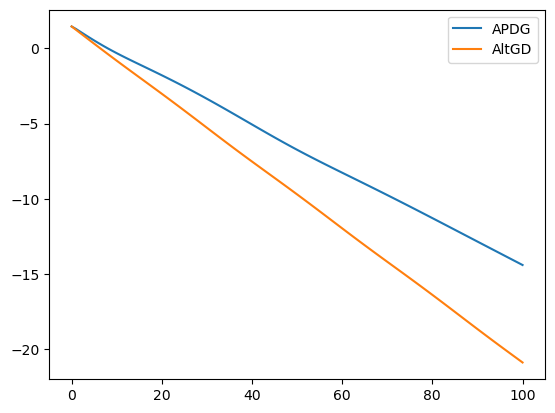

In [24]:
%matplotlib inline
import numpy as np
plt.plot(np.log(loss_f3[0]), label="APDG")
plt.plot(np.log(loss_f3[1]), label="AltGD")
plt.legend()